In [14]:
import pandas as pd
import numpy as np
from kss import split_sentences
from pykospacing import Spacing
from hanspell import spell_checker
from konlpy.tag import Okt, Kkma, Hannanum, Komoran, Mecab
import re
from textrankr import TextRank
from typing import List
import matplotlib.pyplot as plt
from tqdm import tqdm
from gensim.models import Word2Vec


In [9]:
answer_out = np.load('dataset/answer_out_ms_1.npy')
answer_in = np.load('dataset/answer_in_ms_1.npy')
questions = np.load('dataset/questions_ms_1.npy')

In [12]:
len(answer_in)

5100

In [11]:
a = (' '.join(questions) + ' '.join(answer_in) + ' '.join(answer_out)).split()
len(set(a))

12847

In [40]:
questions

array(['분리 불안장애 심하다 강아지 종류 는 뭔가 요 분리 불안장애 강아지 종류 는 다 분리 불안장애 오다 건가 요',
       '진도 강아지 세 살 제 가 외출 하울링 하다 불안장애 훈련 중 인데 집 훈련 이랑 잠자리 도 분리 해주다 게 좋다 대서 제 바로 옆 에 강아지 침대 놓다 자다',
       '그래서 강아지 하다 마리 데려오다 하다 괜찮다', ...,
       '저희 집 에 살 강아지 하다 마리 있다 요즘 약간 갑자기 심하다 낑낑대다 낑낑대다 안다 달다 전 에 잠깐 가지 고 놀다 닭 장난감 갑자기 자기 분신 처럼 엄청 갖다 다니다 막 구석 에 들어가다 해 요',
       '보 니까 학교 도 가야 되다 학원 도 가야 되다 강아지 혼자 있다 시간 이 너무 많다 것 같다',
       '내공 강아지 강아지 위험하다 동거 인가요'], dtype='<U139')

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
all_sentences = list(questions) + list(answer_in) + list(answer_out)

# Word_Index_Voca 작성
tokenizer = Tokenizer(filters=' ', lower=False, oov_token='<OOV>')

tokenizer.fit_on_texts(all_sentences)

NameError: name 'questions' is not defined

In [27]:
# 상위 호출
for word, idx in tokenizer.word_index.items():
    print(f'{word}\t >>> \t{idx}')
    if idx > 10:
        break

<OOV>	 >>> 	1
강아지	 >>> 	2
이	 >>> 	3
을	 >>> 	4
<START>	 >>> 	5
<END>	 >>> 	6
에	 >>> 	7
가	 >>> 	8
하다	 >>> 	9
것	 >>> 	10
를	 >>> 	11


In [37]:
tokens = list(tokenizer.word_index.keys())

In [18]:
# 토크나이저 워드 길이
len(tokenizer.word_index)

12846

In [19]:
np.save('model/tokenizer.npy', tokenizer)

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
question_sequence = tokenizer.texts_to_sequences(questions)
answer_in_sequence = tokenizer.texts_to_sequences(answer_in)
answer_out_sequence = tokenizer.texts_to_sequences(answer_out)

In [23]:
print(question_sequence[:10])

[[381, 56, 436, 2, 258, 12, 527, 17, 381, 56, 2, 258, 12, 52, 381, 56, 111, 298, 17], [5991, 2, 573, 147, 30, 8, 236, 1116, 9, 56, 46, 103, 129, 21, 46, 412, 5992, 13, 381, 295, 29, 169, 3989, 30, 375, 239, 7, 2, 562, 659, 64], [157, 2, 9, 138, 449, 9, 445], [56, 2, 2, 343, 622, 361, 356, 361, 356, 145, 295], [617, 55, 173, 27, 16, 52, 446, 20, 99, 2412, 5501, 797, 14, 3073, 56, 241, 679, 80, 146, 860, 56, 1550, 105, 226, 641, 105, 1031, 758, 190, 219, 1335, 141, 1194, 9, 758], [2, 77, 56, 18, 85], [2, 30, 8, 14, 362, 44, 56, 338, 936, 17], [56, 916, 46, 16, 886, 93, 9, 32], [25, 21, 3, 5502, 11, 1735, 2, 40, 194, 604, 53, 289, 7, 20, 2, 25, 99, 50, 91, 77, 56, 40, 13, 617, 91, 5993, 78, 494, 111, 1089, 1430, 31, 2529, 11, 735, 191, 887], [2, 56, 11513, 2102, 3074]]


In [39]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [43]:
# 토큰화
okt = Okt()
tokenized_data = []
for sen in all_sentences:
    temp_x = okt.morphs(sen, stem = True)
    temp_x = [word for word in temp_x if not word in stopwords]
    tokenized_data.append(temp_x)

문장의 최대 토큰 개수 : 46
문장의 평균 토큰 개수 : 15.53169934640523


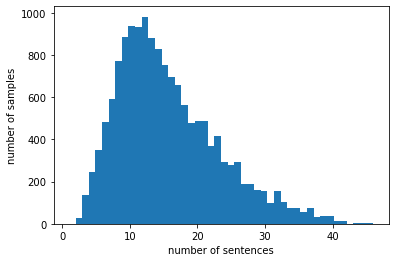

In [46]:
# 문장별 토큰 분포 확인
print('문장의 최대 토큰 개수 :',max(len(l) for l in tokenized_data))
print('문장의 평균 토큰 개수 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=46)
plt.xlabel('number of sentences')
plt.ylabel('number of samples')
plt.show()

In [48]:
# word2vec 학습
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 3, workers=4, sg = 1)

In [70]:
from gensim.models import KeyedVectors
# 학습된 모델 저장
model.wv.save_word2vec_format('test_w2v')
loaded_model =  KeyedVectors.load_word2vec_format('test_w2v')

### 워드 임베딩 모델로부터 2개의 tsv 파일 생성하기

In [75]:
!python -m gensim.scripts.word2vec2tensor --input test_w2v --output test_w2v

C:\ProgramData\Anaconda3\envs\da\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
2021-07-01 09:51:11,618 - word2vec2tensor - INFO - running C:\ProgramData\Anaconda3\envs\da\lib\site-packages\gensim\scripts\word2vec2tensor.py --input test_w2v --output test_w2v
2021-07-01 09:51:11,618 - keyedvectors - INFO - loading projection weights from test_w2v
2021-07-01 09:51:12,023 - utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (4036, 100) matrix of type float32 from test_w2v', 'binary': False, 'encoding': 'utf8', 'datetime': '2021-07-01T09:51:12.022350', 'gensim': '4.0.1', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event

In [74]:
loaded_model.vectors

array([[-2.6049054e-01,  7.7991500e-02,  4.8992403e-02, ...,
        -4.4098520e-01,  1.6346113e-01,  1.4093386e-01],
       [-3.8322750e-01,  1.7960331e-01,  6.8524130e-02, ...,
        -2.3748209e-01,  1.8296970e-01,  1.9399387e-01],
       [-1.6578224e-01, -3.4889810e-05,  1.7194155e-01, ...,
        -1.3591005e-01,  3.8818642e-01,  1.9743215e-01],
       ...,
       [-5.6942724e-02,  1.7155591e-02,  3.7215963e-02, ...,
        -5.9989374e-02,  7.7722524e-03, -5.8937036e-02],
       [-2.7796049e-02, -1.4539381e-02,  2.2272782e-02, ...,
        -1.4640407e-01,  4.0961951e-02, -6.6890538e-02],
       [-3.1245163e-02,  4.9798056e-02,  7.8768032e-03, ...,
        -9.5752537e-02,  1.6505923e-02, -4.5375530e-02]], dtype=float32)

In [50]:
model.wv.vectors[:10]

array([[-2.60490537e-01,  7.79915005e-02,  4.89924029e-02,
         2.32957616e-01, -2.14193344e-01, -3.02454263e-01,
         4.74689960e-01,  5.28668225e-01, -4.14930195e-01,
        -4.60141450e-01,  3.10039282e-01, -8.37918445e-02,
        -9.75146815e-02,  1.64852887e-01, -1.14801712e-01,
         1.22331046e-02,  1.51971236e-01,  1.85186699e-01,
        -5.70385575e-01, -4.03050423e-01,  2.90479690e-01,
        -8.74555632e-02, -3.97107489e-02,  1.15842380e-01,
         2.09373251e-01,  5.98559044e-02, -9.92245078e-02,
        -3.39241847e-02, -1.83002427e-01,  1.90469429e-01,
        -2.79257357e-01,  7.13378638e-02,  4.02563140e-02,
        -1.84752159e-02,  5.43544926e-02,  1.85530946e-01,
         4.10757959e-01, -5.05664289e-01, -3.30557264e-02,
        -4.23666149e-01, -3.51148844e-01,  4.26680818e-02,
        -8.28852728e-02,  9.72136408e-02,  1.46402768e-03,
        -6.68729395e-02, -1.55558676e-01,  1.95463166e-01,
         9.30720642e-02,  1.43622935e-01,  1.19427390e-0

In [52]:
print(model.wv.most_similar("강아지"))


[('물론', 0.6859664916992188), ('그리고', 0.6775661706924438), ('품종', 0.6736265420913696), ('단점', 0.6702815294265747), ('지수', 0.6674889922142029), ('유난히', 0.6646629571914673), ('하지만', 0.6610081195831299), ('곱슬곱슬하다', 0.6607738733291626), ('초롱', 0.6606035828590393), ('여자', 0.6603826880455017)]


In [3]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import tensorflow as tf
import os